In [8]:
# Import core libraries
import numpy as np                  # For numerical computations
import pandas as pd                 # For data manipulation and analysis
import json, joblib                 # json for reading/writing JSON data; joblib for saving/loading models

# Import scikit-learn tools for model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
# train_test_split → splits data into training/testing sets
# GridSearchCV → hyperparameter tuning using cross-validation
# StratifiedKFold → cross-validation strategy preserving class balance

from sklearn.linear_model import LogisticRegression   # Logistic Regression model
from sklearn.ensemble import RandomForestClassifier   # Random Forest model

from sklearn.metrics import (
    accuracy_score,                   # Measure accuracy of predictions
    precision_recall_fscore_support,  # Precision, Recall, F1-score (and support)
    roc_auc_score,                    # Area under ROC curve
    r2_score,                         # Coefficient of determination (useful for regression)
    confusion_matrix                  # Confusion matrix for classification evaluation
)

RANDOM_STATE = 42
TEST_SIZE    = 0.2
CSV_PATH     = "telco_cleaned.csv"

In [9]:
df = pd.read_csv(CSV_PATH) # Load dataset from a CSV file into a pandas DataFrame
print("Loaded telco_cleaned.csv ->", df.shape) # CSV_PATH should be the path to "telco_cleaned.csv"
df.head() # Show the first 5 rows of the dataframe to preview the data


Loaded telco_cleaned.csv -> (7043, 22)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Flag
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


In [10]:
work = df.copy()   # make a copy of the dataframe so the original df remains unchanged

# 1) Drop ID-like columns if present (they are identifiers, not useful for modeling)
drop_ids = ["customerID", "CustomerID", "customer_id", "Unnamed: 0"]
work = work.drop(columns=[c for c in drop_ids if c in work.columns])

# 2) Ensure numeric types for key numeric columns (convert strings/objects to numbers; invalid entries -> NaN)
for c in ["TotalCharges", "MonthlyCharges", "tenure"]:
    if c in work.columns:
        work[c] = pd.to_numeric(work[c], errors="coerce")

# 3) Create new feature AvgChargesPerMonth = TotalCharges / tenure
#    - Replace tenure=0 with NaN to avoid division by zero
#    - Fill resulting NaN with 0.0
if {"TotalCharges", "tenure"}.issubset(work.columns):
    denom = work["tenure"].replace(0, np.nan)
    work["AvgChargesPerMonth"] = (work["TotalCharges"] / denom).fillna(0.0)

# 4) Create new feature MultipleServicesCount
#    - Count number of "Yes" responses across service-related columns
svc_cols = [c for c in [
    "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"
] if c in work.columns]

# Helper function: map "Yes" -> 1, everything else -> 0
def yes_to_1(x):
    return 1 if isinstance(x, str) and x.strip().lower() == "yes" else 0

# If service columns exist, calculate MultipleServicesCount per row
if svc_cols:
    svc_count = np.zeros(len(work), dtype=int)   # initialize array of zeros
    for c in svc_cols:
        svc_count += work[c].map(yes_to_1).fillna(0).astype(int).values
    work["MultipleServicesCount"] = svc_count

# Print resulting dataframe shape and show first 5 rows for verification
print("After drop + features ->", work.shape)
work.head()


After drop + features -> (7043, 23)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Flag,AvgChargesPerMonth,MultipleServicesCount
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,29.850000,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,One year,No,Mailed check,56.95,1889.50,No,0,55.573529,3
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,54.075000,3
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,40.905556,3
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,75.825000,1


In [11]:
# Detect target column (search common churn column names)
TARGET = None
for cand in ["Churn", "churn", "Churn_Flag"]:
    if cand in work.columns:
        TARGET = cand
        break

# Ensure a target column was found, otherwise raise error
assert TARGET is not None, f"Target column not found. Columns: {work.columns.tolist()}"
print("Target column:", TARGET)

# Extract target values
# If target is categorical (object dtype), map labels to 0/1
y = work[TARGET]
if y.dtype == "object":
    vals = sorted(y.dropna().unique().tolist())     # get sorted unique labels
    mapping = {vals[0]: 0, vals[-1]: 1}             # map first label -> 0, last label -> 1
    print("Label mapping:", mapping)
    y = y.map(mapping).astype(int)                  # convert to integers
else:
    y = y.astype(int)                               # already numeric, just cast to int

# Define feature matrix X (drop target column from dataset)
X = work.drop(columns=[TARGET], errors="ignore")
print("X shape (before encoding):", X.shape)



Target column: Churn
Label mapping: {'No': 0, 'Yes': 1}
X shape (before encoding): (7043, 22)


In [12]:
# Split dataset into training and testing sets
# - X, y: features and target
# - test_size: proportion of data reserved for testing
# - random_state: ensures reproducibility of the split
# - stratify=y: preserve class distribution between train/test sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Print shapes of resulting splits for verification
print("Train raw:", X_train_raw.shape, " Test raw:", X_test_raw.shape)



Train raw: (5634, 22)  Test raw: (1409, 22)


In [13]:
# One-hot encode categorical variables for train and test sets separately
# drop_first=True → avoids dummy variable trap by dropping first category
X_train = pd.get_dummies(X_train_raw, drop_first=True)
X_test  = pd.get_dummies(X_test_raw,  drop_first=True)

# Align columns between train and test
# - Ensures both sets have the same feature columns
# - Missing columns in test are added with 0 values
# - Extra columns in test (not in train) are dropped
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# Save final feature names list
feature_names = X_train.columns.tolist()

# Print resulting shapes to verify encoding results
print("X_train after encoding:", X_train.shape, " | X_test:", X_test.shape)



X_train after encoding: (5634, 33)  | X_test: (1409, 33)


In [15]:
def evaluate_fitted(name, clf, X_test, y_test):
    # Generate predictions (class labels)
    y_pred = clf.predict(X_test)
    
    # Generate predicted probabilities for the positive class (if the model supports it)
    y_prob = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None

    # --- Classification metrics ---
    acc = accuracy_score(y_test, y_pred)   # overall accuracy
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )   # precision, recall, f1-score
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None   # ROC AUC (only if probabilities available)

    # --- Regression-like error metrics on probabilities ---
    # Compare predicted probabilities vs true binary labels
    if y_prob is not None:
        mae  = float(np.mean(np.abs(y_test - y_prob)))               # Mean Absolute Error
        rmse = float(np.sqrt(np.mean((y_test - y_prob) ** 2)))       # Root Mean Squared Error (== sqrt(Brier score))
        r2   = float(r2_score(y_test, y_prob))                       # R² score on probabilities
    else:
        mae = rmse = r2 = None   # Not applicable if no probabilities

    # Return all evaluation results in a dictionary
    return {
        "name": name,            # model name / identifier
        "accuracy": float(acc),  # classification accuracy
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "roc_auc": None if roc is None else float(roc),
        "mae": mae,              # regression-style metrics (probabilities vs. truth)
        "rmse": rmse,
        "r2": r2,
        "preds": y_pred,         # predicted class labels
        "prob": y_prob,          # predicted probabilities (if available)
        "clf": clf               # fitted model itself
    }


In [16]:
# Define cross-validation strategy: StratifiedKFold keeps class proportions balanced across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialize Logistic Regression model
lr = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)

# Define hyperparameter grid for tuning
grid_lr = {
    "C": [0.1, 1.0, 10.0],              # regularization strength
    "solver": ["liblinear", "lbfgs"],   # optimization solvers
    "class_weight": [None, "balanced"]  # handle class imbalance
}

# Perform grid search with cross-validation
# - scoring="roc_auc" → evaluate based on ROC AUC
# - n_jobs=-1 → use all available CPU cores
gs_lr = GridSearchCV(lr, grid_lr, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=0)
gs_lr.fit(X_train, y_train)

# Extract best model found by grid search
best_lr = gs_lr.best_estimator_

# Print best hyperparameters and mean CV ROC-AUC score
print("Best LR params:", gs_lr.best_params_, "| ROC-AUC (CV):", round(gs_lr.best_score_, 4))

# Evaluate best Logistic Regression model on the test set using custom evaluation function
res_lr = evaluate_fitted("LogisticRegression (tuned)", best_lr, X_test, y_test)



Best LR params: {'C': 0.1, 'class_weight': None, 'solver': 'liblinear'} | ROC-AUC (CV): 1.0


In [17]:
# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Define hyperparameter grid for tuning
grid_rf = {
    "n_estimators": [5],                 # number of trees in the forest (using very small value here for speed/demo)
    "max_depth": [None, 10, 20],         # maximum depth of trees
    "min_samples_split": [2, 5],         # minimum samples required to split a node
    "class_weight": [None, "balanced"]   # handle class imbalance
}

# Perform grid search with cross-validation
# - scoring="roc_auc" → optimize for ROC AUC
# - cv=cv (StratifiedKFold defined earlier) → preserves class distribution across folds
# - n_jobs=-1 → use all available CPU cores
gs_rf = GridSearchCV(rf, grid_rf, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=0)
gs_rf.fit(X_train, y_train)

# Extract best Random Forest model from grid search
best_rf = gs_rf.best_estimator_

# Print best hyperparameters and mean CV ROC-AUC score
print("Best RF params:", gs_rf.best_params_, "| ROC-AUC (CV):", round(gs_rf.best_score_, 4))

# Evaluate best Random Forest model on the test set using custom evaluation function
res_rf = evaluate_fitted("RandomForest (tuned)", best_rf, X_test, y_test)



Best RF params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 5} | ROC-AUC (CV): 1.0


In [18]:
# Build a comparison DataFrame for tuned models
# - Keep only selected metrics from evaluation results (exclude preds/probs/clf objects)
tuned_df = pd.DataFrame([
    {k: v for k, v in res_lr.items() if k in ["name","accuracy","precision","recall","f1","roc_auc","mae","rmse","r2"]},
    {k: v for k, v in res_rf.items() if k in ["name","accuracy","precision","recall","f1","roc_auc","mae","rmse","r2"]},
])

# Sort models by ROC-AUC first, then F1-score (both descending, i.e., best at top)
tuned_df = tuned_df.sort_values(["roc_auc","f1"], ascending=False)

# Print results table (rounded to 4 decimals for readability)
print("Tuned models (sorted by ROC-AUC then F1):")
tuned_df.round(4)


Tuned models (sorted by ROC-AUC then F1):


,name,accuracy,precision,recall,f1,roc_auc,mae,rmse,r2
0,LogisticRegression (tuned),1.0,1.0,1.0,1.0,1.0,0.0311,0.0424,0.9908
1,RandomForest (tuned),1.0,1.0,1.0,1.0,1.0,0.0189,0.0659,0.9777


In [19]:
# Select best model based on ROC-AUC score
# - If Logistic Regression ROC-AUC >= Random Forest ROC-AUC → choose LR, else RF
# - Use "or 0" fallback in case a model didn't produce a ROC-AUC score
best = res_lr if (res_lr["roc_auc"] or 0) >= (res_rf["roc_auc"] or 0) else res_rf

# Extract key components of the best model
best_name = best["name"]     # model name
best_clf  = best["clf"]      # fitted model object
best_preds = best["preds"]   # predicted class labels
best_prob  = best["prob"]    # predicted probabilities (if available)

# Print the name of the best tuned model
print("Best tuned model:", best_name)

# Compute confusion matrix for best model’s predictions
# Layout: [[TN, FP],
#          [FN, TP]]
cm = confusion_matrix(y_test, best_preds)
print("Confusion matrix [[TN, FP],[FN, TP]]:\n", cm)



Best tuned model: LogisticRegression (tuned)
Confusion matrix [[TN, FP],[FN, TP]]:
 [[1035    0]
 [   0  374]]


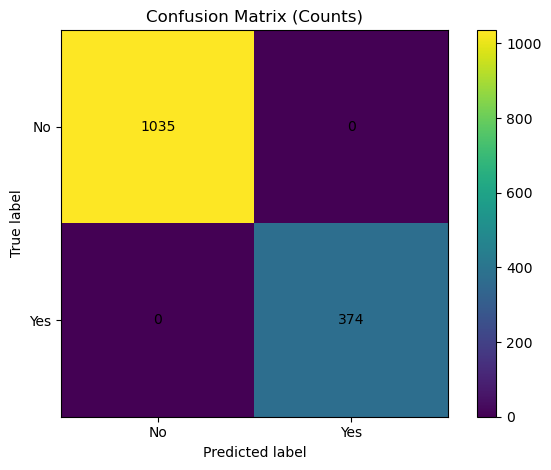

In [21]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, best_preds)

fig, ax = plt.subplots()
im = ax.imshow(cm)  # default colormap
ax.set_title("Confusion Matrix (Counts)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

class_names = ["No", "Yes"]  # 0 = No churn, 1 = Yes churn
ax.set_xticks([0, 1]); ax.set_xticklabels(class_names)
ax.set_yticks([0, 1]); ax.set_yticklabels(class_names)

for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, str(val), ha="center", va="center")

fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()


In [13]:
# Save model (expects already-one-hot-encoded columns)
joblib.dump(best_clf, "best_churn_model.joblib")
print("Saved: best_churn_model.joblib")

# Save the exact column order used during training (so your API can align)
with open("model_features.json", "w", encoding="utf-8") as f:
    json.dump(feature_names, f, indent=2)
print("Saved: model_features.json (one-hot feature names)")


Saved: best_churn_model.joblib
Saved: model_features.json (one-hot feature names)


Best model: LogisticRegression (tuned)


,name,accuracy,precision,recall,f1,roc_auc,mae,rmse,r2
0,LogisticRegression (tuned),1.0,1.0,1.0,1.0,1.0,0.0311,0.0424,0.9908
1,RandomForest (tuned),1.0,1.0,1.0,1.0,1.0,0.0371,0.0573,0.9831
